# Bottleneck Transformers for CIFAR-10 Image Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
batch_size = 64
num_workers = 4
lr = 0.1
weight_decay = 1e-4
momentum = 0.9
print_intervals = 100
gradient_clip = 2.0

In [ ]:
# Load the data

def load_data():
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_dataset = CIFAR10('./data', train=True, transform=train_transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_dataset = CIFAR10('./data', train=False, transform=test_transform, download=True)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
# Model definition
#Inspired from https://github.com/leaderj1001/BottleneckTransformers

class MHSA(nn.Module):
    def __init__(self, n_dims, width=14, height=14, heads=4):
        super(MHSA, self).__init__()
        self.heads = heads

        self.query = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.key = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.value = nn.Conv2d(n_dims, n_dims, kernel_size=1)

        self.rel_h = nn.Parameter(torch.randn([1, heads, n_dims // heads, 1, height]), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn([1, heads, n_dims // heads, width, 1]), requires_grad=True)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        n_batch, C, width, height = x.size()
        q = self.query(x).view(n_batch, self.heads, C // self.heads, -1)
        k = self.key(x).view(n_batch, self.heads, C // self.heads, -1)
        v = self.value(x).view(n_batch, self.heads, C // self.heads, -1)

        content_content = torch.matmul(q.permute(0, 1, 3, 2), k)

        content_position = (self.rel_h + self.rel_w).view(1, self.heads, C // self.heads, -1).permute(0, 1, 3, 2)
        content_position = torch.matmul(content_position, q)

        energy = content_content + content_position
        attention = self.softmax(energy)

        out = torch.matmul(v, attention.permute(0, 1, 3, 2))
        out = out.view(n_batch, C, width, height)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, heads=4, mhsa=False, resolution=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        if not mhsa:
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        else:
            self.conv2 = nn.ModuleList()
            self.conv2.append(MHSA(planes, width=int(resolution[0]), height=int(resolution[1]), heads=heads))
            if stride == 2:
                self.conv2.append(nn.AvgPool2d(2, 2))
            self.conv2 = nn.Sequential(*self.conv2)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# reference
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000, resolution=(224, 224), heads=4):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.resolution = list(resolution)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if self.conv1.stride[0] == 2:
            self.resolution[0] /= 2
        if self.conv1.stride[1] == 2:
            self.resolution[1] /= 2
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # for ImageNet
        #if self.maxpool.stride == 2:
            #self.resolution[0] /= 2
            #self.resolution[1] /= 2

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, heads=heads, mhsa=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3), # All architecture deeper than ResNet-200 dropout_rate: 0.2
            nn.Linear(512 * block.expansion, num_classes)
        )

    def _make_layer(self, block, planes, num_blocks, stride=1, heads=4, mhsa=False):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for idx, stride in enumerate(strides):
            layers.append(block(self.in_planes, planes, stride, heads, mhsa, self.resolution))
            if stride == 2:
                self.resolution[0] /= 2
                self.resolution[1] /= 2
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        # out = self.maxpool(out) # for ImageNet

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


def ResNet50(num_classes=10, resolution=(32, 32), heads=4):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, resolution=resolution, heads=heads)

In [ ]:
cuda_available = torch.cuda.is_available()
device = torch.device('cuda') if cuda_available else torch.device('cpu')
# define model and add to gpu
model = ResNet50().to(device)
# load data
train_loader, test_loader = load_data()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
criterion = nn.CrossEntropyLoss()
num_epoch = 50

100%|██████████| 170498071/170498071 [00:05<00:00, 29672104.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's see some of the images we'll be working with.

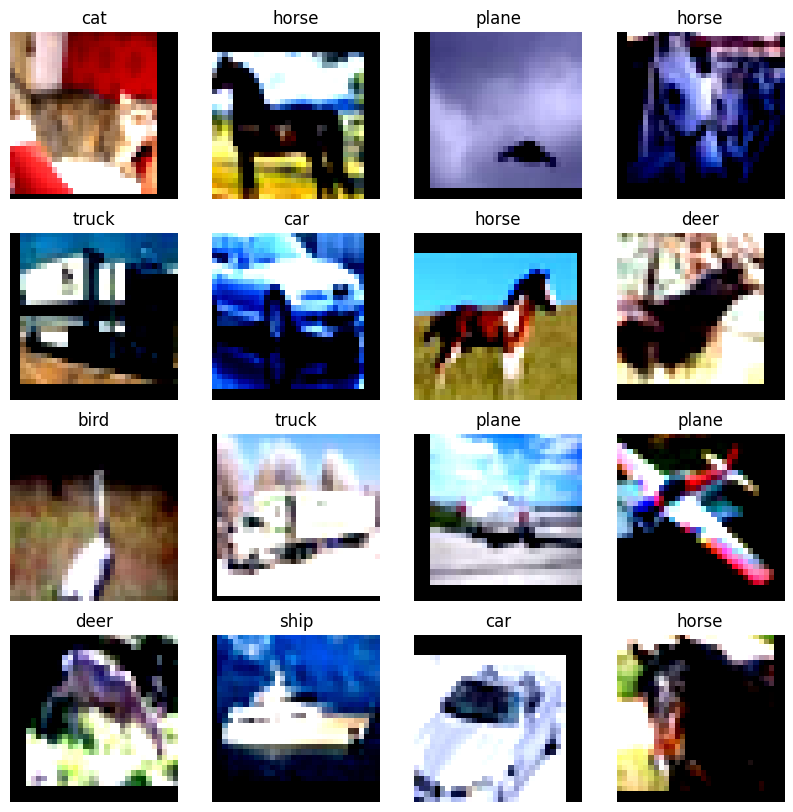

In [ ]:
#Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Show images in a grid
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

Let's define a `train` function as well as a `test` function:

In [ ]:
def train(train_loader, epoch):
    model.train()
    losses = 0.
    acc = 0.
    total = 0.
    for idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        output = model(data)
        _, pred = F.softmax(output, dim=-1).max(1)
        acc += pred.eq(target).sum().item()
        total += target.size(0)

        optimizer.zero_grad()
        loss = criterion(output, target)
        losses += loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)

        optimizer.step()

        if idx % print_intervals == 0 and idx != 0:
            print('[Epoch: {0:4d}], Loss: {1:.3f}, Acc: {2:.3f}, Correct {3} / Total {4}'.format(epoch,
                                                                                                 losses / (idx + 1),
                                                                                                 acc / total * 100.,
                                                                                                 acc, total))

In [ ]:
def test(test_loader, epoch):
    model.eval()

    acc = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = F.softmax(output, dim=-1).max(1)

            acc += pred.eq(target).sum().item()
        print('[Epoch: {0:4d}], Acc: {1:.3f}'.format(epoch, acc / len(test_loader.dataset) * 100.))

    return acc / len(test_loader.dataset) * 100.

Now we can execute the training loop.

In [ ]:
# Cosine annealing refers to reducing the learning rate following a cosine curve.
# help the model to converge to better solutions.
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.0001)

#TRAINING
global_acc = 0.
for epoch in range(1, num_epoch + 1):
    train(train_loader, epoch)
    best_acc = test(test_loader, epoch)

    lr_scheduler.step()
    print('Current Learning Rate: {}'.format(lr_scheduler.get_last_lr()))

[Epoch:    1], Loss: 3.955, Acc: 14.140, Correct 914.0 / Total 6464.0
[Epoch:    1], Loss: 4.481, Acc: 15.617, Correct 2009.0 / Total 12864.0
[Epoch:    1], Loss: 4.847, Acc: 15.371, Correct 2961.0 / Total 19264.0
[Epoch:    1], Loss: 4.813, Acc: 16.303, Correct 4184.0 / Total 25664.0
[Epoch:    1], Loss: 4.952, Acc: 17.153, Correct 5500.0 / Total 32064.0
[Epoch:    1], Loss: 5.010, Acc: 17.869, Correct 6873.0 / Total 38464.0
[Epoch:    1], Loss: 5.026, Acc: 18.540, Correct 8318.0 / Total 44864.0
[Epoch:    1], Acc: 28.890
Current Learning Rate: [0.09755527298894293]
[Epoch:    2], Loss: 3.849, Acc: 26.439, Correct 1709.0 / Total 6464.0
[Epoch:    2], Loss: 3.780, Acc: 27.332, Correct 3516.0 / Total 12864.0
[Epoch:    2], Loss: 3.896, Acc: 28.011, Correct 5396.0 / Total 19264.0
[Epoch:    2], Loss: 3.696, Acc: 28.815, Correct 7395.0 / Total 25664.0
[Epoch:    2], Loss: 3.502, Acc: 29.276, Correct 9387.0 / Total 32064.0
[Epoch:    2], Loss: 3.331, Acc: 29.422, Correct 11317.0 / Total 38

After training the model, we test on the test dataloader.

In [ ]:
#EVAL
test(test_loader, 1)

[Epoch:    1], Acc: 85.060


85.06

Now we can display some of the test images with the actual and predicted labels.

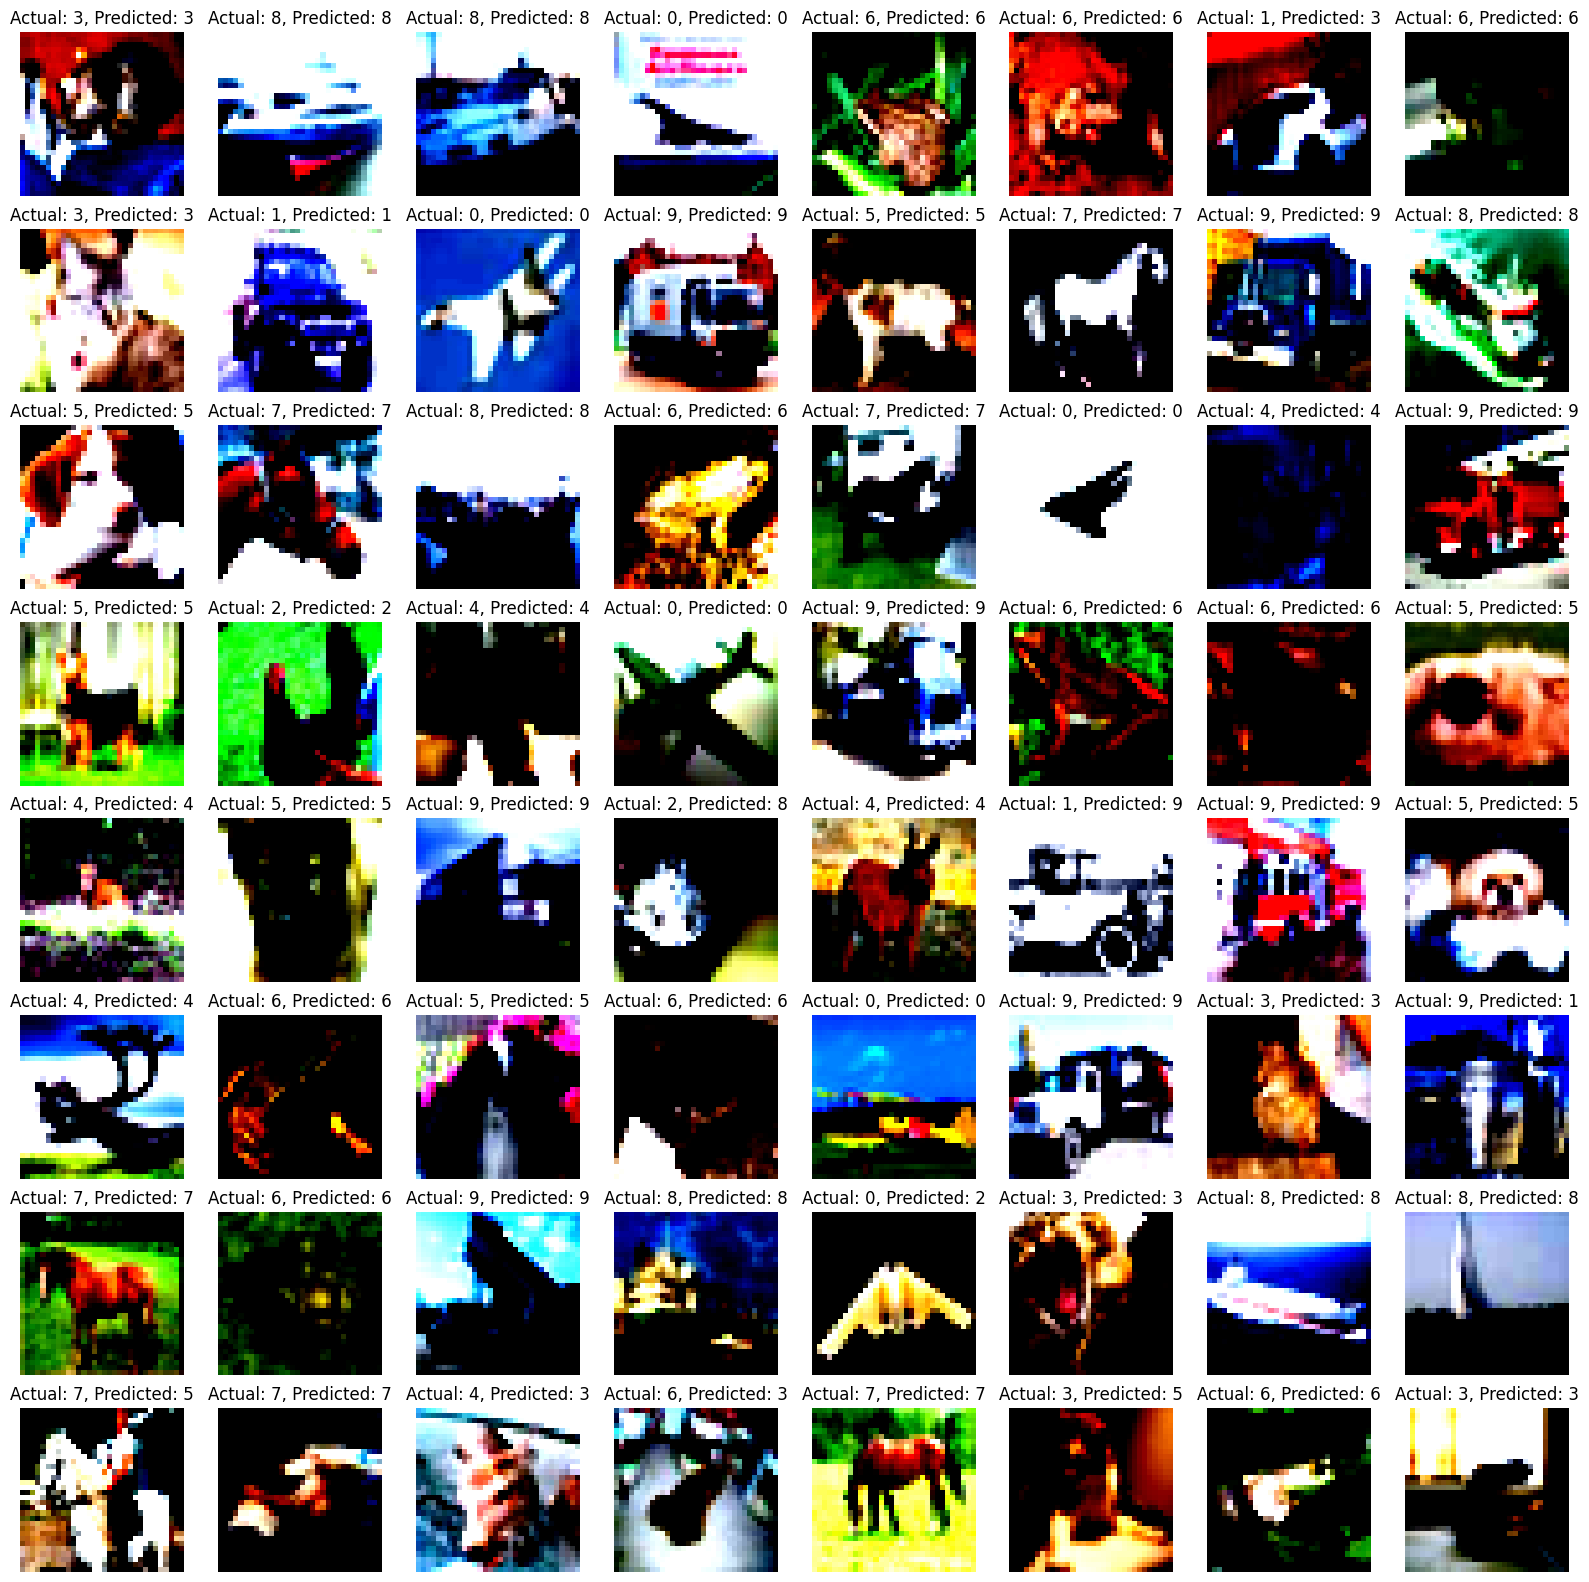

In [ ]:
# Assuming 'images', 'labels' are from your dataloader and 'model' is your trained model


model.eval()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = F.softmax(output, dim=-1).max(1)
        images = data.cpu()
        target = target.cpu()
        pred = pred.cpu()

        # Display images and compare actual and predicted labels
        plt.figure(figsize=(20, 20))  # Adjust the figure size
        for i in range(len(images)):
            plt.subplot(8, 8, i + 1)  # Configure for a grid of 8x8
            plt.imshow(images[i].permute(1, 2, 0))  # Adjust image tensor format for display
            plt.title(f'Actual: {target[i]}, Predicted: {pred[i]}')
            plt.axis('off')
        plt.show()

        break  # Break after the first batch
